In [32]:
#Note: Try to execute all the cells in a Sequential Manner
#References: 1.torch.ipynb shared by professor. Used it to generate the Modeling part i.e Part 1
#            2. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/ to understand and genertate Gensim to word2vecc

In [17]:
#Importing all the packages
import pandas as pd
import string,nltk,json
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from nltk.util import ngrams
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
train_df = pd.read_csv('news-train-1.csv')
test_df = pd.read_csv("news-test.csv")

# Preprocessing from HW1

In [19]:
#Preprocessing code from HW1
ps = PorterStemmer()
remove_punctuation = dict((ord(char), None) for char in string.punctuation)
def get_processed_tokens(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [word for word in tokens if not word in stopwords.words('english')]
    lemmatized_words = [ps.stem(item) for item in filtered]
    Cleaned_text = ' '.join(lemmatized_words)
    return Cleaned_text
train_df['cleaned_text'] = train_df['Text'].apply(lambda x: get_processed_tokens(x))
test_df['cleaned_text'] = test_df['Text'].apply(lambda x: get_processed_tokens(x))

In [20]:
# Function to generate bigrams for a given text
def generate_bigrams(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Generate bigrams
    bigrams = list(ngrams(tokens, 2))
    return bigrams

train_df['bigrams'] = train_df['cleaned_text'].apply(lambda x: generate_bigrams(x))

In [ ]:
# Function to get the keywords
def get_keywords(text):
  doc = nlp(text)
  keywords = [token.text for token in doc if token.pos_ in ["NOUN", "ADJ"]]
  return keywords

train_df['keywords'] = train_df['cleaned_text'].apply(lambda x: get_keywords(x))

# Building Neural Network Model in Torch

In [21]:
##To maintain all the accuracies across different features
features_list = []
train_accuracy_scores = []
test_accuracy_scores = []
train_accuracy_stddev = []
test_accuracy_stddev = []

In [22]:
#neural network class with 2 hidden layers
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size1)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_size1, hidden_size2)
        nn.init.kaiming_uniform_(self.layer_2.weight, nonlinearity="relu")
        self.layer_3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [23]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [24]:
#performs model evaluation
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * (correct / total)

In [25]:
# Train the model
def train_model(model,optimizer,train_dataloader,loss_fn):
    for epoch in range(100):
        for X, y in train_dataloader:
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y.long())
            loss.backward()
            optimizer.step()

In [26]:
 # Convert data to DataLoader format
def data_format(X_train_split,y_train_split,X_val_split,y_val_split):
    train_data = Data(X_train_split, y_train_split)
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    val_data = Data(X_val_split, y_val_split)
    val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)
    return train_loader,val_loader

In [27]:
def perform_k_fold_CV(X_train, y_train,feature_method):
    # Split the data using 5-fold cross-validation
    kf = KFold(n_splits=5)
    train_per = []
    val_per = []

    for ind1, ind2 in kf.split(np.array(X_train)):
        #initialize the model for each fold
        model = NeuralNetwork(X_train.shape[1], 128, 128, len(np.unique(y_train)))
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        X_train_split, X_val_split = np.array(X_train)[ind1], np.array(X_train)[ind2]
        y_train_split, y_val_split = np.array(y_train)[ind1], np.array(y_train)[ind2]

        # Convert data to DataLoader format
        train_loader,val_loader = data_format(X_train_split,y_train_split,X_val_split,y_val_split)

        # Train the model
        train_model(model,optimizer,train_loader,loss_fn)

        # Evaluate on training and validation data
        train_per.append(evaluate(model, train_loader))
        val_per.append(evaluate(model, val_loader))

    print(f"Train accuraccy: {train_per}")
    print(f"Evaluation accuraccy: {val_per}")

    #store all the accuracies
    features_list.append(feature_method)
    train_accuracy_scores.append(np.mean(train_per))
    test_accuracy_scores.append(np.mean(val_per))
    train_accuracy_stddev.append(np.std(train_per))
    test_accuracy_stddev.append(np.std(val_per))

# Different Features Exploration

In [ ]:
X_train = train_df['cleaned_text'].copy()
y_train = train_df['Category'].copy()

In [ ]:
#Transform your text data using Count Vectorizer
vectorizer = CountVectorizer()
X_train_trans = vectorizer.fit_transform(X_train)
X_train_trans = X_train_trans.toarray()

#Encode the y_train data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
perform_k_fold_CV(X_train_trans, y_train_encoded,"Count Vectorizer")

Train accuraccy: [100.0, 100.0, 100.0, 100.0, 100.0]
Evaluation accuraccy: [95.77464788732394, 95.77464788732394, 98.12206572769952, 96.22641509433963, 97.64150943396226]


In [ ]:
#Transform your text data using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()

#Perform LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
perform_k_fold_CV(X_train_tfidf, y_train_encoded,"TF-IDF")

Train accuraccy: [100.0, 100.0, 100.0, 100.0, 100.0]
Evaluation accuraccy: [96.71361502347418, 97.65258215962442, 98.59154929577466, 96.22641509433963, 98.58490566037736]


**Gensim with Glove -> Word2Vec**

you can find different versions of Glove in below URL:
http://nlp.stanford.edu/data/glove.6B.zip
Dowload Glove file:
https://nlp.stanford.edu/projects/glove/

I have referred the below article to understand Glove with gensim:
https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [ ]:
glove_input_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-136-8338421c53c6>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
X = train_df['cleaned_text']
y = train_df['Category']

# Create word embeddings for text data
X_vectors = []
for text in X:
    # Split the text into words
    words = text.split()
    vectors = [glove_model[word] if word in glove_model else np.zeros(50) for word in words]
    if vectors:
        avg_vector = np.mean(vectors, axis=0)
    else:
        avg_vector = np.zeros(50)  # GloVe vectors are 50-dimensional
    X_vectors.append(avg_vector)
X_vectors = np.array(X_vectors)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
perform_k_fold_CV(X_vectors, y_train_encoded,"glove2word2vec")

Train accuraccy: [100.0, 100.0, 100.0, 100.0, 100.0]
Evaluation accuraccy: [92.95774647887323, 93.89671361502347, 95.77464788732394, 94.81132075471697, 96.22641509433963]


#Display Results

In [ ]:
results_dataframe = pd.DataFrame({
        "Feature Method": features_list,
        "Train Accuracy": train_accuracy_scores,
        "Test Accuracy": test_accuracy_scores,
        "Train Standard Deviation": train_accuracy_stddev,
        "Test Standard Deviation":test_accuracy_stddev
    })
# styling the results
sns.set_style("whitegrid")
display(results_dataframe)

,Feature Method,Train Accuracy,Test Accuracy,Train Standard Deviation,Test Standard Deviation
0,Count Vectorizer,100.0,96.707857,0.0,0.984402
1,TF-IDF,100.0,97.553813,0.0,0.961012
2,glove2word2vec,100.0,94.733369,0.0,1.197694


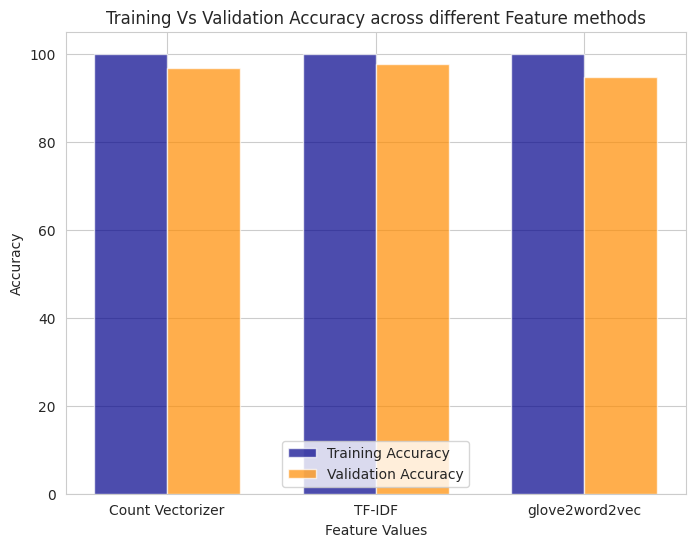

In [ ]:
bar_width = 0.35
index = np.arange(len(features_list))

plt.figure(figsize=(8, 6))
plt.bar(index, train_accuracy_scores, label='Training Accuracy', alpha=0.7, color='darkblue', width=bar_width)
plt.bar(index + bar_width, test_accuracy_scores, label='Validation Accuracy', alpha=0.7, color='darkorange', width=bar_width)
plt.xlabel('Feature Values')
plt.ylabel('Accuracy')
plt.title('Training Vs Validation Accuracy across different Feature methods')
plt.xticks(index + bar_width / 2, features_list)
plt.legend(loc='lower center')
plt.show()


# PART 2A

The best feature engineering method from the modeling part is TF-IDF

In [ ]:
def train_model_with_learning_rates(X_train, y_train,learning_rates):

    avg_train_accuracies = []
    std_train_accuracies = []
    avg_val_accuracies = []
    std_val_accuracies = []

    for lr in learning_rates:
        # Split the data using 5-fold cross-validation
        kf = KFold(n_splits=5)
        train_accuracies = []
        val_accuracies = []

        for ind1, ind2 in kf.split(np.array(X_train)):
            #initialize the model for each fold
            model = NeuralNetwork(X_train.shape[1], 128, 128, len(np.unique(y_train)))
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr)
            X_train_split, X_val_split = np.array(X_train)[ind1], np.array(X_train)[ind2]
            y_train_split, y_val_split = np.array(y_train)[ind1], np.array(y_train)[ind2]

            # Convert data to DataLoader format
            train_loader,val_loader = data_format(X_train_split,y_train_split,X_val_split,y_val_split)

            # Train the model
            train_model(model,optimizer,train_loader,loss_fn)

            # Evaluate on training and validation data
            train_accuracies.append(evaluate(model, train_loader))
            val_accuracies.append(evaluate(model, val_loader))

        avg_train_accuracies.append(np.mean(train_accuracies))
        std_train_accuracies.append(np.std(train_accuracies))
        avg_val_accuracies.append(np.mean(val_accuracies))
        std_val_accuracies.append(np.std(val_accuracies))

    results_dataframe = pd.DataFrame({
        "Learning Rate": learning_rates,
        "Avg Train Accuracy": avg_train_accuracies,
        "Std Train Accuracy": std_train_accuracies,
        "Avg Val Accuracy": avg_val_accuracies,
        "Std Val Accuracy": std_val_accuracies,
    })
    sns.set_style("whitegrid")
    display(results_dataframe)
    return avg_train_accuracies,avg_val_accuracies

In [ ]:
X_train = train_df['cleaned_text'].copy()
y_train = train_df['Category'].copy()

In [ ]:
learning_rates =  [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
train_accuracies,val_accuracies = train_model_with_learning_rates(X_train_tfidf, y_train_encoded,learning_rates)

,Learning Rate,Avg Train Accuracy,Std Train Accuracy,Avg Val Accuracy,Std Val Accuracy
0,0.0001,100.0,0.0,97.554256,0.862048
1,0.0003,100.0,0.0,97.272123,1.002811
2,0.0010,100.0,0.0,97.648153,0.986504
3,0.0030,100.0,0.0,97.272123,0.751532
4,0.0100,100.0,0.0,95.394189,2.773315
5,0.0300,100.0,0.0,95.484100,1.100002
6,0.1000,100.0,0.0,94.732040,0.750605


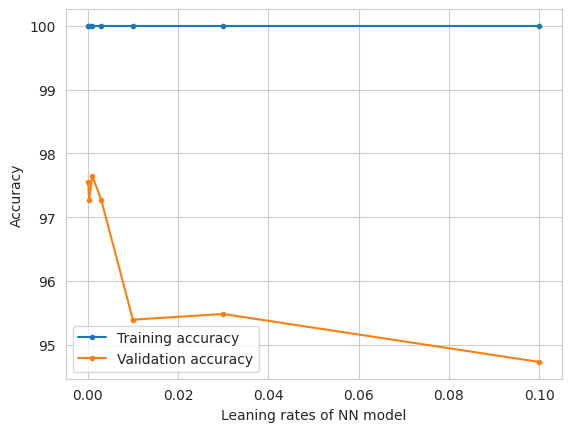

In [ ]:
#Plotting the training and validation accuracies w.r.t min samples leaf
print("\n")
plt.plot(learning_rates, train_accuracies, marker='.', label="Training accuracy")
plt.plot(learning_rates, val_accuracies, marker='.', label="Validation accuracy")
plt.xlabel('Leaning rates of NN model')
plt.ylabel('Accuracy')
plt.legend()

# PART 2B

In [ ]:
def train_model_with_optimizers(X_train, y_train, optimizers):
    avg_train_accuracies = []
    std_train_accuracies = []
    avg_val_accuracies = []
    std_val_accuracies = []

    for optimizer_name in optimizers:
        # Split the data using 5-fold cross-validation
        kf = KFold(n_splits=5)
        train_accuracies = []
        val_accuracies = []
        leaning_rate = 0.001

        for ind1, ind2 in kf.split(np.array(X_train)):
            #initialize the model for each fold
            model = NeuralNetwork(X_train.shape[1], 128, 128, len(np.unique(y_train)))
            loss_fn = nn.CrossEntropyLoss()
            optimizer_map = {
                    "SGD": optim.SGD,
                    "Adam": optim.Adam,
                    "RMSprop": optim.RMSprop
            }

            if optimizer_name in optimizer_map:
                optimizer = optimizer_map[optimizer_name](model.parameters(), lr=leaning_rate)
            else:
                print(f"Not a Valid optimizer: {optimizer_name}")

            X_train_split, X_val_split = np.array(X_train)[ind1], np.array(X_train)[ind2]
            y_train_split, y_val_split = np.array(y_train)[ind1], np.array(y_train)[ind2]

            # Convert data to DataLoader format
            train_loader,val_loader = data_format(X_train_split,y_train_split,X_val_split,y_val_split)

            # Train the model
            train_model(model,optimizer,train_loader,loss_fn)

            # Evaluate on training and validation data
            train_accuracies.append(evaluate(model, train_loader))
            val_accuracies.append(evaluate(model, val_loader))

        avg_train_accuracies.append(np.mean(train_accuracies))
        std_train_accuracies.append(np.std(train_accuracies))
        avg_val_accuracies.append(np.mean(val_accuracies))
        std_val_accuracies.append(np.std(val_accuracies))

    results_dataframe = pd.DataFrame({
        "Optimizers": optimizers,
        "Avg Train Accuracy": avg_train_accuracies,
        "Std Train Accuracy": std_train_accuracies,
        "Avg Val Accuracy": avg_val_accuracies,
        "Std Val Accuracy": std_val_accuracies,
    })
    sns.set_style("whitegrid")
    display(results_dataframe)
    return avg_train_accuracies,avg_val_accuracies

In [ ]:
X_train = train_df['cleaned_text'].copy()
y_train = train_df['Category'].copy()

In [ ]:
optimizers =  ["SGD", "Adam", "RMSprop"]

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
train_accuracies,val_accuracies = train_model_with_optimizers(X_train_tfidf, y_train_encoded,optimizers)

,Optimizers,Avg Train Accuracy,Std Train Accuracy,Avg Val Accuracy,Std Val Accuracy
0,SGD,22.554614,1.631484,21.822571,2.825511
1,Adam,100.000000,0.000000,97.460360,1.175269
2,RMSprop,100.000000,0.000000,97.178670,0.984394


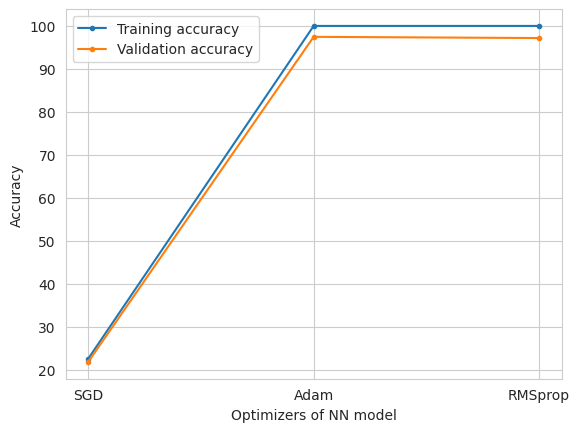

In [ ]:
#Plotting the training and validation accuracies w.r.t min samples leaf
print("\n")
plt.plot(optimizers, train_accuracies, marker='.', label="Training accuracy")
plt.plot(optimizers, val_accuracies, marker='.', label="Validation accuracy")
plt.xlabel('Optimizers of NN model')
plt.ylabel('Accuracy')
plt.legend()

# PART 3

From section I get best results at learning_rate=0.001 and optimizer = Adam and Vectorizer as TF-IDF

In [28]:
def test_model(X_train, y_train, X_test):

    # Initialize the model
    model = NeuralNetwork(X_train.shape[1], 128, 128, len(np.unique(y_train)))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert training data to DataLoader format
    train_data = Data(X_train, y_train)
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

    # Convert test data to DataLoader format
    test_data = Data(X_test, np.zeros(X_test.shape[0]))
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    ## Train the model
    train_model(model,optimizer,train_loader,loss_fn)

    acc = evaluate(model, train_loader)

    print(f"Train accuraccy: {acc}")

    # Make predictions on the test data
    predictions = []
    with torch.no_grad():
        for X, _ in test_loader:
            pred = model(X)
            predictions.extend(torch.argmax(pred, dim=1).tolist())

    return predictions

In [29]:
X_train = train_df['cleaned_text'].copy()
y_train = train_df['Category'].copy()
X_test = test_df['cleaned_text'].copy()

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Convert data to numpy arrays
X_train_tfidf = np.array(X_train_tfidf)
y_train_encoded = np.array(y_train_encoded)
X_test_tfidf = np.array(X_test_tfidf)
predictions = test_model(X_train_tfidf, y_train_encoded,X_test_tfidf)

Train accuraccy: 100.0


In [33]:
# Decode the predictions back to their original category labels
y_test_predicted = label_encoder.inverse_transform(predictions)

test_df['Category'] = y_test_predicted

test_df = test_df[["ArticleId","Category"]]
test_df.to_csv('labels.csv', index=False,header=False)